## Load the fama french dataset

In [30]:
import sys
sys.path.append('../src')

from data_loader import load_sector_data, get_seasonal_returns, calculate_sector_ratio

from timeseries_analysis import (
    reshape_to_timeseries,
    calculate_sp500_returns_ts,
    calculate_smga_returns_ts,
    calculate_sector_rotation_returns_ts,
    calculate_szne_returns_ts,
    calculate_modified_szne_returns_ts,
    calculate_long_short_returns_ts,
    filter_period,
)

from fama_french_analysis import (
    run_fama_french_regression,
    print_regression_summary,
    create_regression_summary_table,
    plot_regression_diagnostics,
    plot_factor_loadings,
    plot_alpha_comparison,
    plot_rolling_alpha,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import pandas as pd

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Setup complete!")

✓ Setup complete!


## load up fama factors for regression

In [31]:
# loading data and converting into reusable ff factors regression input

# Load the data
file_path = '../data/Seasonal S&P Data as of 11.13.2025 - Abhi.xlsx'
factor_series = {}
factor_skiprows = [(1, "Mkt-RF"), (59, "SMB"), (117, "HML"), (175, "rf")]
for skiprows, factor in factor_skiprows:
    df_monthly = load_sector_data(file_path, "SMB_HML", skiprows, numrows=56)
    ts = reshape_to_timeseries(df_monthly).sort_index()
    ts = pd.to_numeric(ts, errors="coerce")  # ensure numeric
    ts.name = factor
    factor_series[factor] = ts
factors_df = pd.concat(factor_series.values(), axis=1)
factors_df.index.name = "Date"

display(factors_df.head())


,Mkt-RF,SMB,HML,rf
Date,,,,
1970-01-01,-8.100,2.910,3.170,0.600
1970-02-01,5.140,-2.390,3.690,0.620
1970-03-01,-1.060,-2.310,4.080,0.570
1970-04-01,-10.990,-6.140,6.140,0.500
1970-05-01,-6.900,-4.610,3.320,0.530


## load up datasets we want to run regressions on

In [32]:
df_sp500 = load_sector_data(file_path, 'S&P500')
df_tbills = load_sector_data(file_path, 'RF')
df_cyclical = load_sector_data(file_path, 'Discretionary')
df_defense = load_sector_data(file_path, 'Staples')
df_pacer = load_sector_data(file_path, 'SZNE')
df_defense = load_sector_data(file_path, 'Staples')
df_industrials = load_sector_data(file_path, 'Industrials')
df_tech = load_sector_data(file_path, 'Tech')
df_communications = load_sector_data(file_path, 'Comm. Services')
df_financials = load_sector_data(file_path, 'Financials')
df_energy = load_sector_data(file_path, 'Energy')
df_materials = load_sector_data(file_path, 'Materials')
df_healthcare = load_sector_data(file_path, 'Healthcare')
df_utilities = load_sector_data(file_path, 'Utilities')
df_realestate = load_sector_data(file_path, 'Real Estate')
df_interest = load_sector_data(file_path, 'Interest Rate')

print("SP 500 data:")
print(f"  Years: {df_sp500.index.min()} - {df_sp500.index.max()}")
print(f"  Shape: {df_sp500.shape}")

print("\nTbills data:")
print(f"  Years: {df_tbills.index.min()} - {df_tbills.index.max()}")
print(f"  Shape: {df_tbills.shape}")


sp500_excess = calculate_sp500_returns_ts(df_sp500, df_tbills)
sp500_excess = filter_period(sp500_excess, start_year=1995, end_year=2025)
print(f"\nS&P 500 excess returns calculated")
print(f"Total observations: {len(sp500_excess)}")
print(f"Date range: {sp500_excess.index.min()} to {sp500_excess.index.max()}")

smga_excess = calculate_smga_returns_ts(df_sp500, df_tbills)
smga_excess = filter_period(smga_excess, start_year=1995, end_year=2025)
print(f"\nSMGA excess returns calculated")
print(f"Total observations: {len(smga_excess)}")
print(f"Date range: {smga_excess.index.min()} to {smga_excess.index.max()}")


rotation_returns = calculate_sector_rotation_returns_ts(df_cyclical, df_defense, df_tbills)
rotation_returns = filter_period(rotation_returns, start_year=1995, end_year=2025)
print(f"\nSector rotation returns calculated")
print(f"Total observations: {len(rotation_returns)}")
print(f"Date range: {rotation_returns.index.min()} to {rotation_returns.index.max()}")

# though function says S&P500, the underlying timeseries calculation is the same
pacer_returns = calculate_sp500_returns_ts(df_pacer, df_tbills)

print(f"\nPacer returns calculated")
print(f"Total observations: {len(pacer_returns)}")
print(f"Date range: {pacer_returns.index.min()} to {pacer_returns.index.max()}")


pacer_returns_repl = calculate_szne_returns_ts(
    df_cyclical,
    df_industrials,
    df_tech,
    df_materials,
    df_defense,
    df_healthcare,
    df_tbills,
)
pacer_returns_repl = filter_period(pacer_returns_repl, start_year=1995, end_year=2025)
print(f"\nSZNE replica returns calculated")
print(f"Total observations: {len(pacer_returns_repl)}")
print(f"Date range: {pacer_returns_repl.index.min()} to {pacer_returns_repl.index.max()}")


modified_pacer = calculate_modified_szne_returns_ts(
    df_cyclical,
    df_industrials,
    df_tech,
    df_materials,
    df_communications,
    df_financials,
    df_energy,
    df_defense,
    df_healthcare,
    df_utilities,
    df_realestate,
    df_tbills,
    df_interest,
)
modified_pacer = filter_period(modified_pacer, start_year=1995, end_year=2025)
print(f"SZNE modified returns calculated")
print(f"Total observations: {len(modified_pacer)}")
print(f"Date range: {modified_pacer.index.min()} to {modified_pacer.index.max()}")

long_short = calculate_long_short_returns_ts(df_cyclical, df_defense, df_tbills)
long_short = filter_period(long_short, start_year=1995, end_year=2025)
print(f"Long short returns calculated")
print(f"Total observations: {len(long_short)}")
print(f"Date range: {long_short.index.min()} to {long_short.index.max()}")



SP 500 data:
  Years: 1970 - 2025
  Shape: (56, 12)

Tbills data:
  Years: 1970 - 2025
  Shape: (56, 12)

S&P 500 excess returns calculated
Total observations: 370
Date range: 1995-01-01 00:00:00 to 2025-10-01 00:00:00

SMGA excess returns calculated
Total observations: 370
Date range: 1995-01-01 00:00:00 to 2025-10-01 00:00:00

Sector rotation returns calculated
Total observations: 370
Date range: 1995-01-01 00:00:00 to 2025-10-01 00:00:00

Pacer returns calculated
Total observations: 87
Date range: 2018-08-01 00:00:00 to 2025-10-01 00:00:00

SZNE replica returns calculated
Total observations: 370
Date range: 1995-01-01 00:00:00 to 2025-10-01 00:00:00
SZNE modified returns calculated
Total observations: 288
Date range: 2001-11-01 00:00:00 to 2025-10-01 00:00:00
Long short returns calculated
Total observations: 370
Date range: 1995-01-01 00:00:00 to 2025-10-01 00:00:00


## Run fama regression

In [33]:
# Run regressions and tabulate results across periods
strategies = {
    'S&P500': sp500_excess['excess'],
    'SMGA': smga_excess['excess'],
    'Rotation': rotation_returns['excess'],
    'Pacer': pacer_returns['excess'],
    'Pacer Repl': pacer_returns_repl['excess'],
    'Pacer Modified': modified_pacer['excess'],
    'Long Short': long_short['excess'],
}

def run_regressions(strategy_map):
    cleaned = {}
    for name, series in strategy_map.items():
        ser = series.dropna()
        if len(ser) == 0:
            print(f"Skipping {name}: no data in this period")
            continue
        cleaned[name] = ser
    if not cleaned:
        raise ValueError("No data available for regression in this period.")
    return {
        name: run_fama_french_regression(series, ff_factors=factors_df)
        for name, series in cleaned.items()
    }

def summarize(title, results_dict):
    summary_df = create_regression_summary_table(results_dict)
    summary_df["Alpha (monthly %)"] 
    summary_df["Alpha (annual %)"]
    summary_df = summary_df.round({
        'Alpha (monthly %)': 3,
        'Alpha (annual %)': 3,
        'Alpha p-value': 3,
        'Beta (Market)': 3,
        'Beta (SMB)': 3,
        'Beta (HML)': 3,
        'R²': 3,
        'Adj R²': 3,
    })
    print(f"\n{title}")
    print(summary_df)
    return summary_df

# Full-period regressions (1995-2025)
regression_results = run_regressions(strategies)

# Keep individual result variables for downstream plots
results_sp500 = regression_results.get('S&P500')
results_smga = regression_results.get('SMGA')
results_rotation = regression_results.get('Rotation')
results_pacer = regression_results.get('Pacer')
results_pacer_repl = regression_results.get('Pacer Repl')
results_pacer_mod = regression_results.get('Pacer Modified')
results_long_short = regression_results.get('Long Short')

summary_full = summarize('Fama-French regression summary (coefficients, 1995-2025)', regression_results)

# Additional period slices
periods = [
    ('1995-2006', 1995, 2006),
    ('2008-2025', 2008, 2025),
    ('2018-2025', 2018, 2025),
]

period_summaries = {}
for label, start, end in periods:
    sliced = {name: filter_period(series, start_year=start, end_year=end) for name, series in strategies.items()}
    results = run_regressions(sliced)
    period_summaries[label] = summarize(f'Fama-French regression summary (coefficients, {label})', results)



Fama-French regression summary (coefficients, 1995-2025)
                Alpha (monthly %)  Alpha (annual %)  Alpha p-value  \
Strategy                                                             
S&P500                     -0.148            -1.781          0.000   
SMGA                        0.086             1.035          0.457   
Rotation                    0.137             1.649          0.384   
Pacer                      -0.620            -7.441          0.017   
Pacer Repl                  0.132             1.578          0.275   
Pacer Modified             -0.121            -1.450          0.311   
Long Short                  0.168             2.016          0.508   

                Beta (Market)  Beta (SMB)  Beta (HML)    R²  Adj R²    N  
Strategy                                                                  
S&P500                  0.988      -0.178       0.030 0.993   0.992  369  
SMGA                    0.483      -0.118       0.065 0.484   0.480  369  
Rotation   

## Plot regression

S&P500 plots


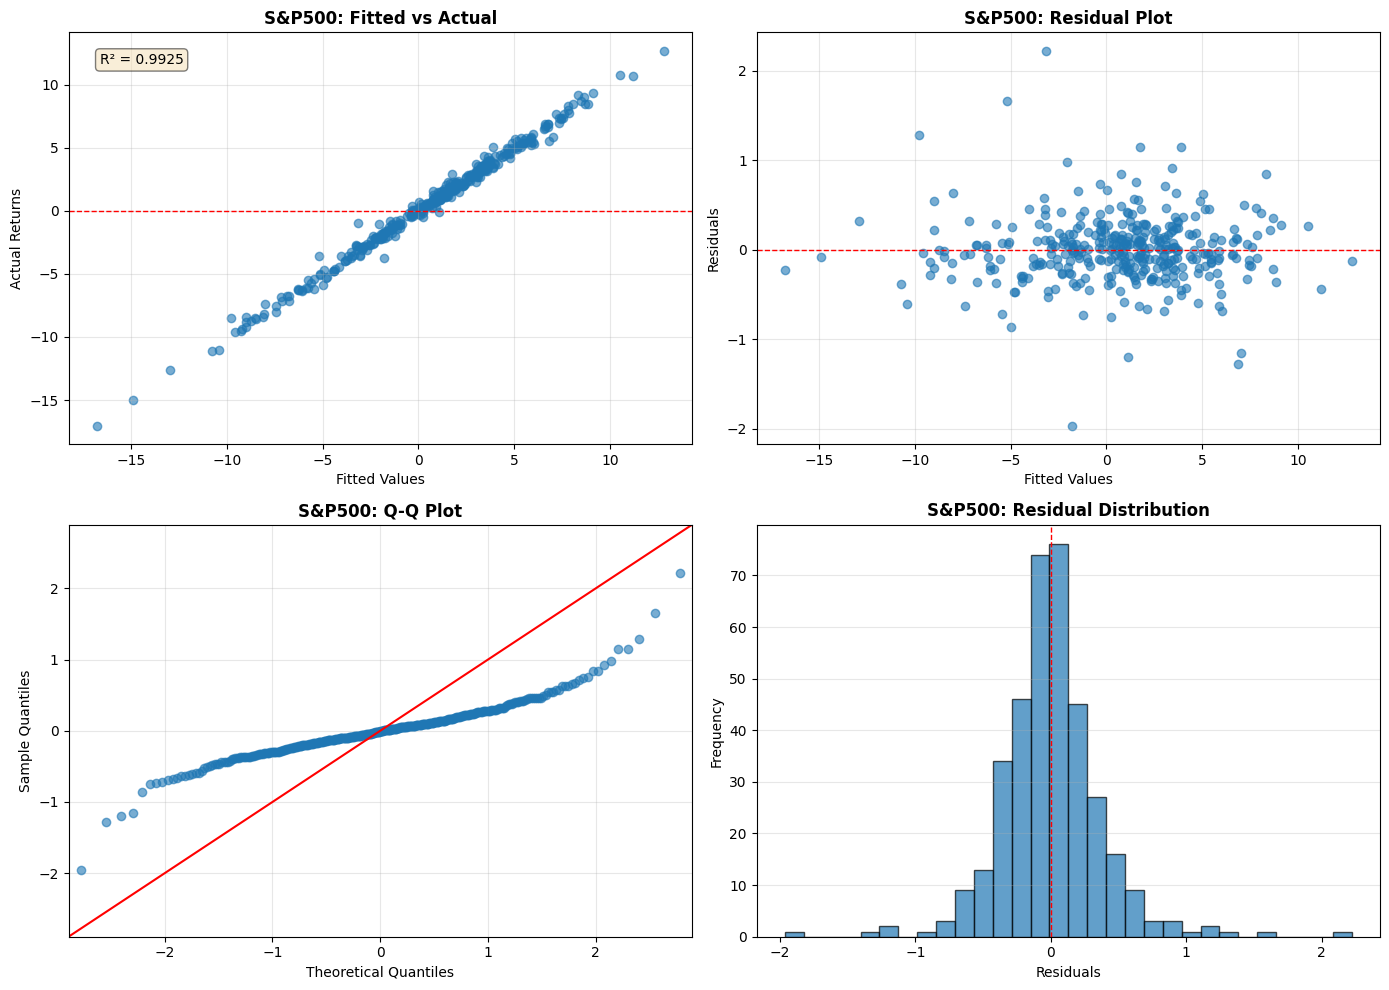

SMGA plots


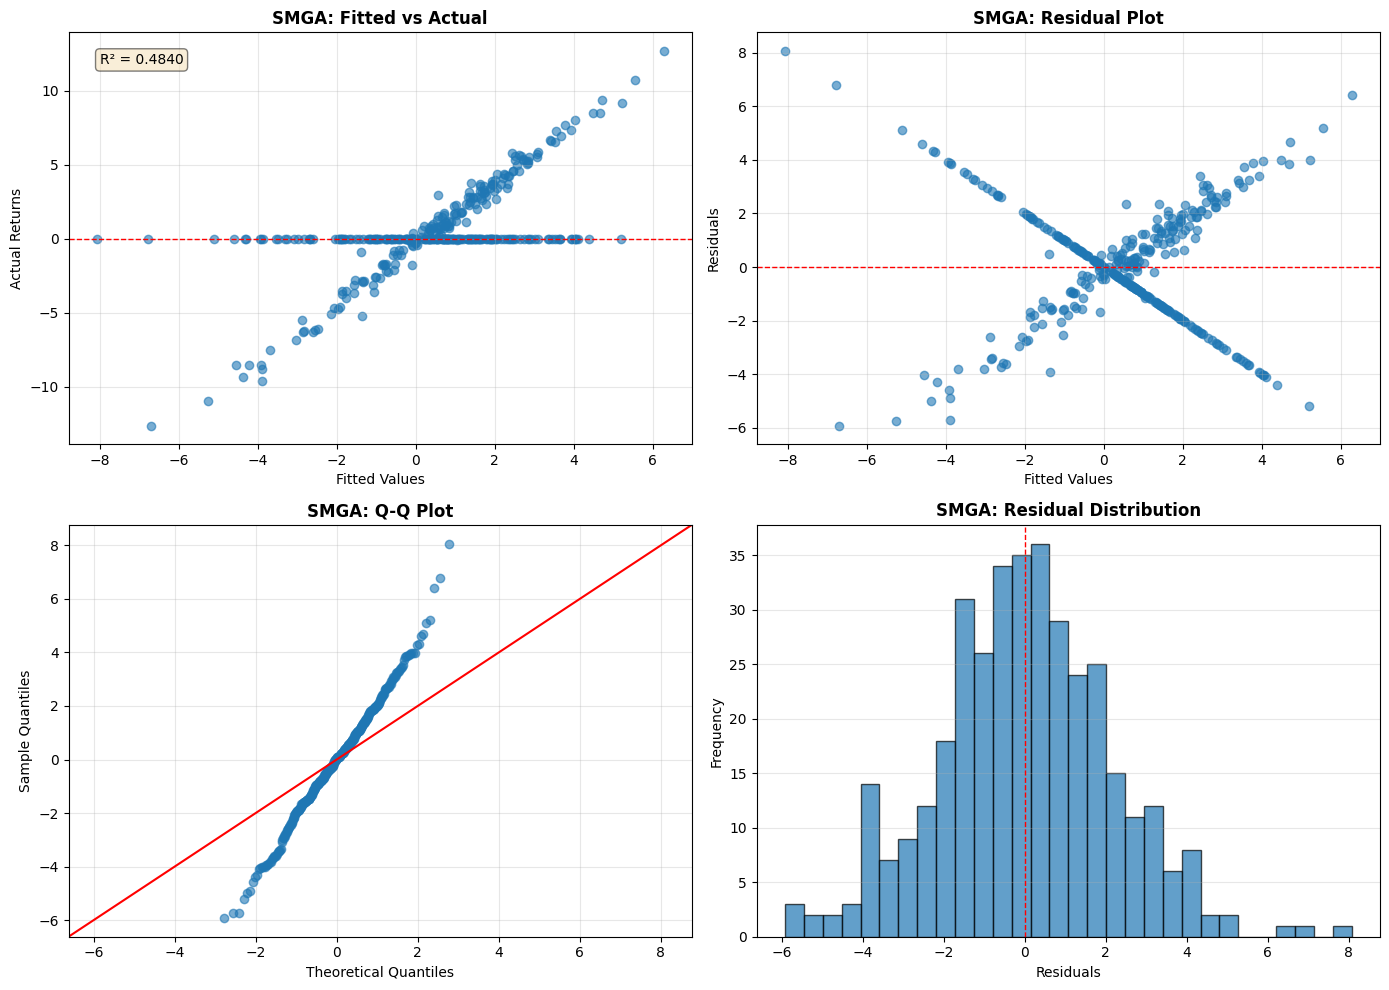

Rotation plots


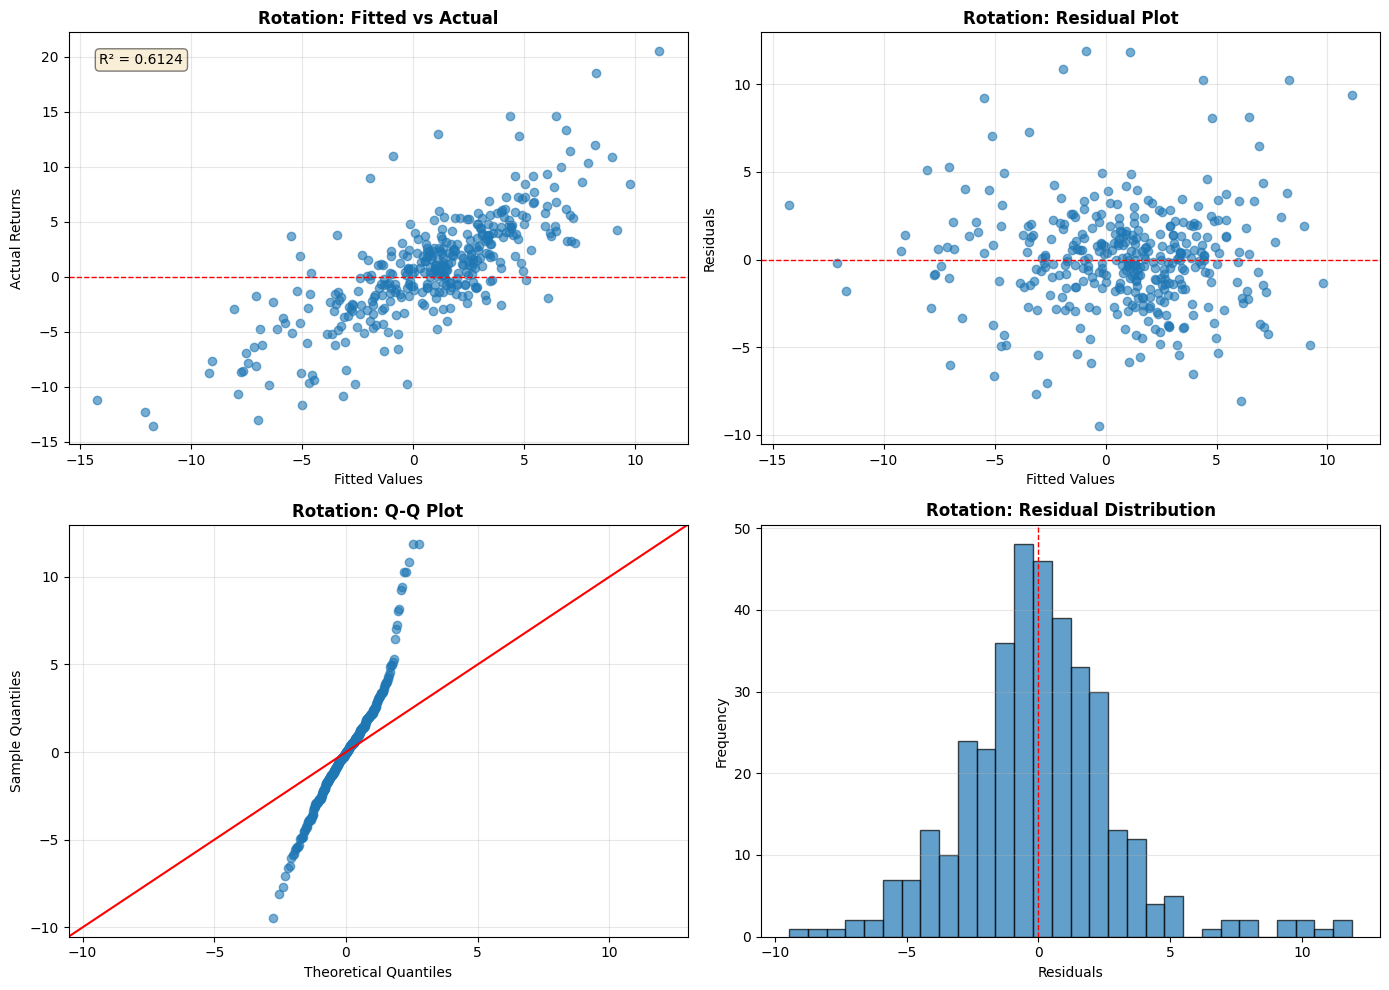

Pacer plots


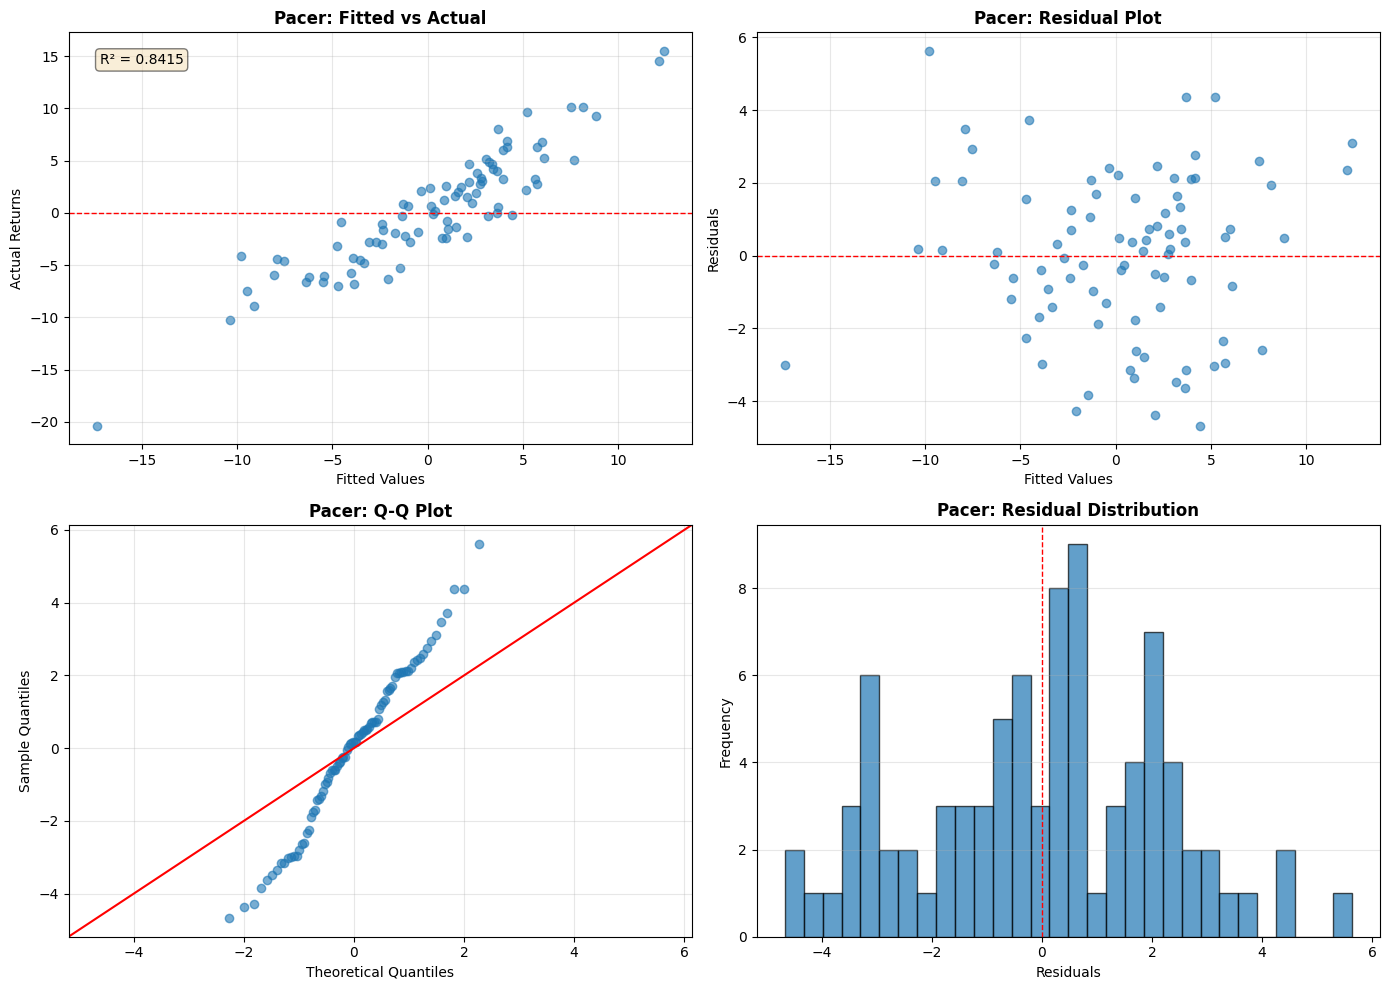

Pacer Repl plots


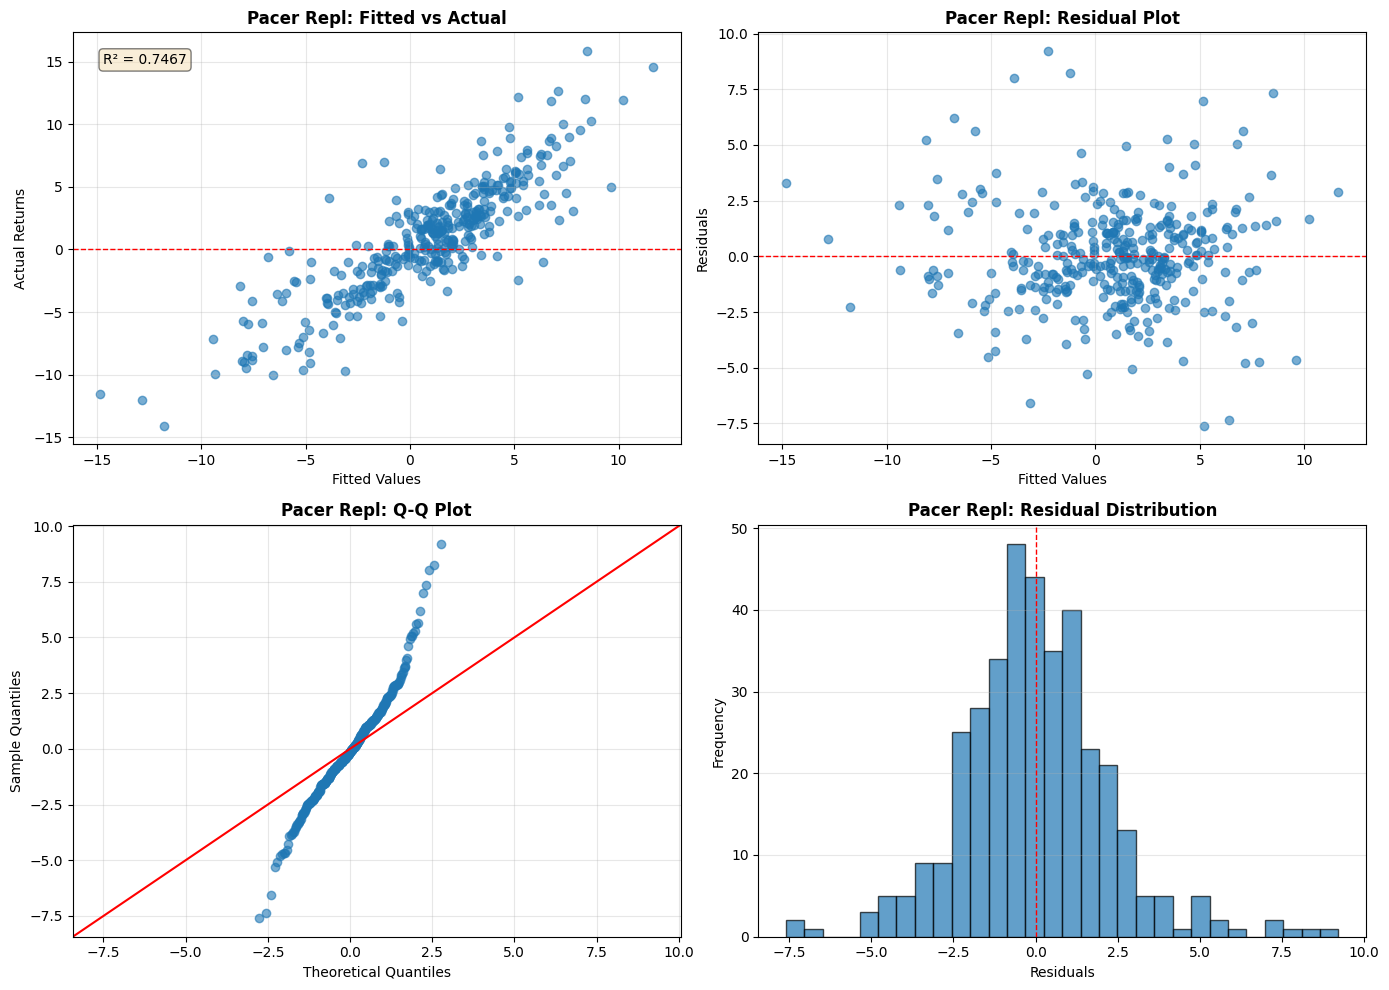

Pacer Modified plots


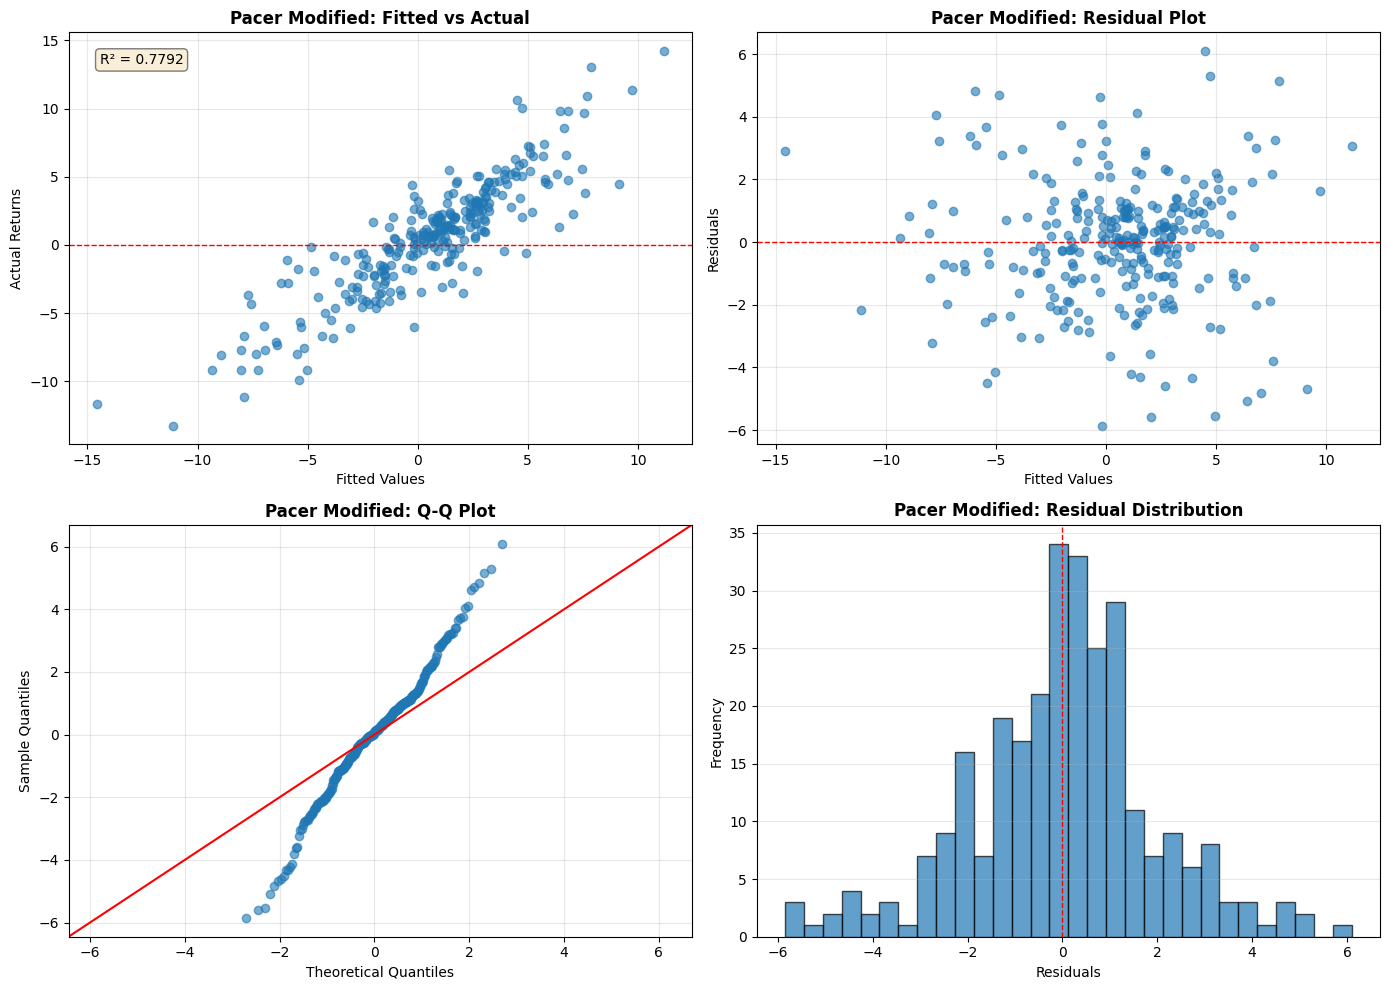

Long Short plots


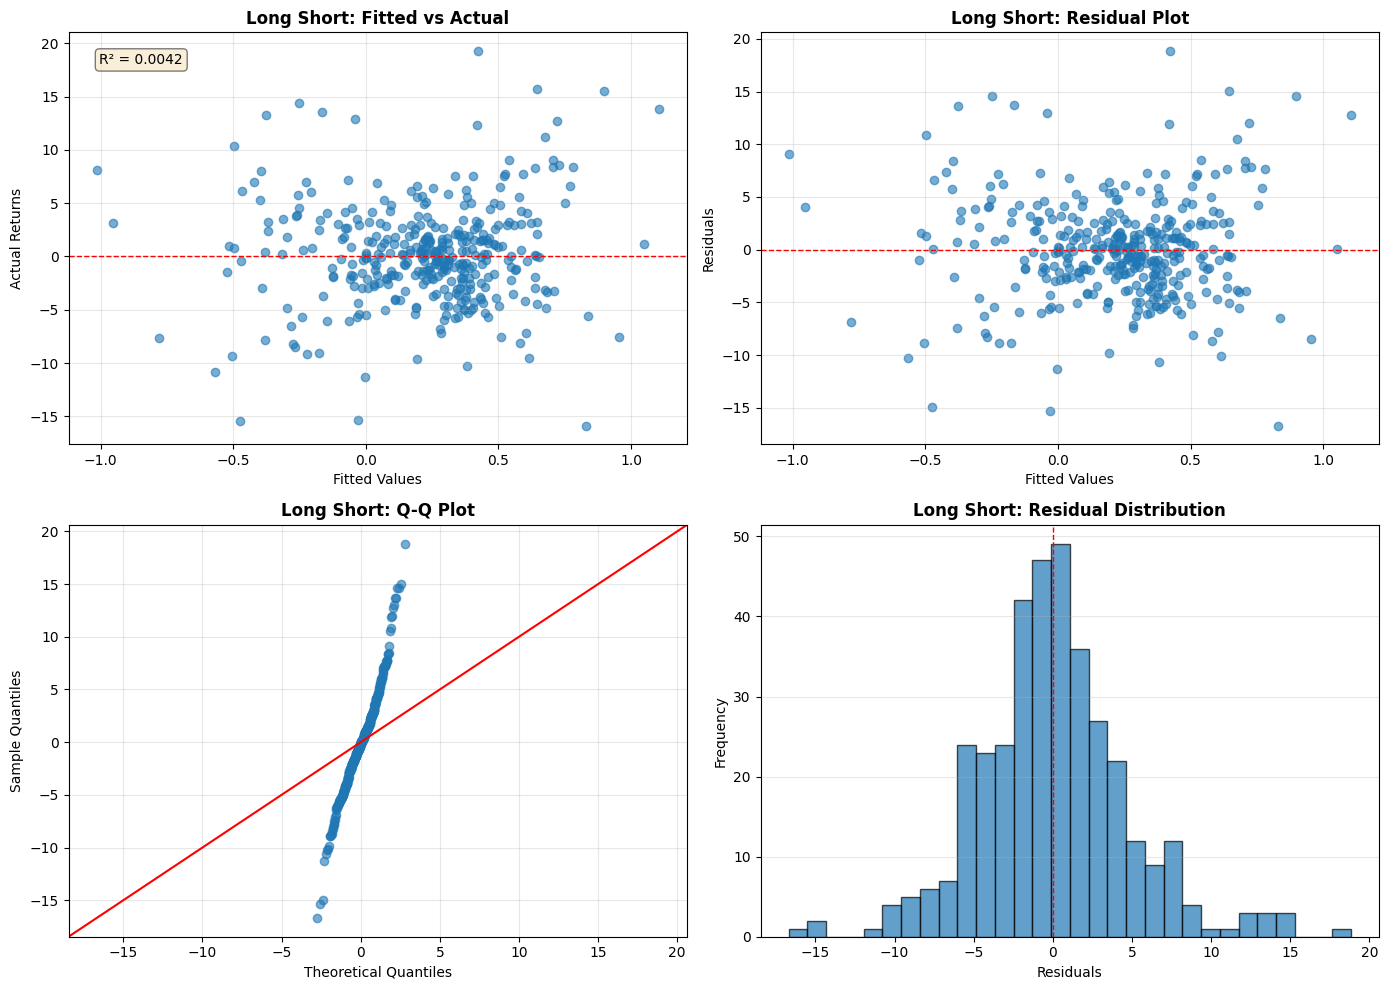

In [34]:
strategies = [
    ("S&P500", sp500_excess, results_sp500),
    ("SMGA", smga_excess, results_smga),
    ("Rotation", rotation_returns, results_rotation),
    ("Pacer", pacer_returns, results_pacer),
    ("Pacer Repl", pacer_returns_repl, results_pacer_repl),
    ("Pacer Modified", modified_pacer, results_pacer_mod),
    ("Long Short", long_short, results_long_short),
]

for name, series, res in strategies:
    print("=" * 24)
    print(f"{name} plots")
    print("=" * 24)
    plot_regression_diagnostics(series, res, name)


## Rolling window alphas

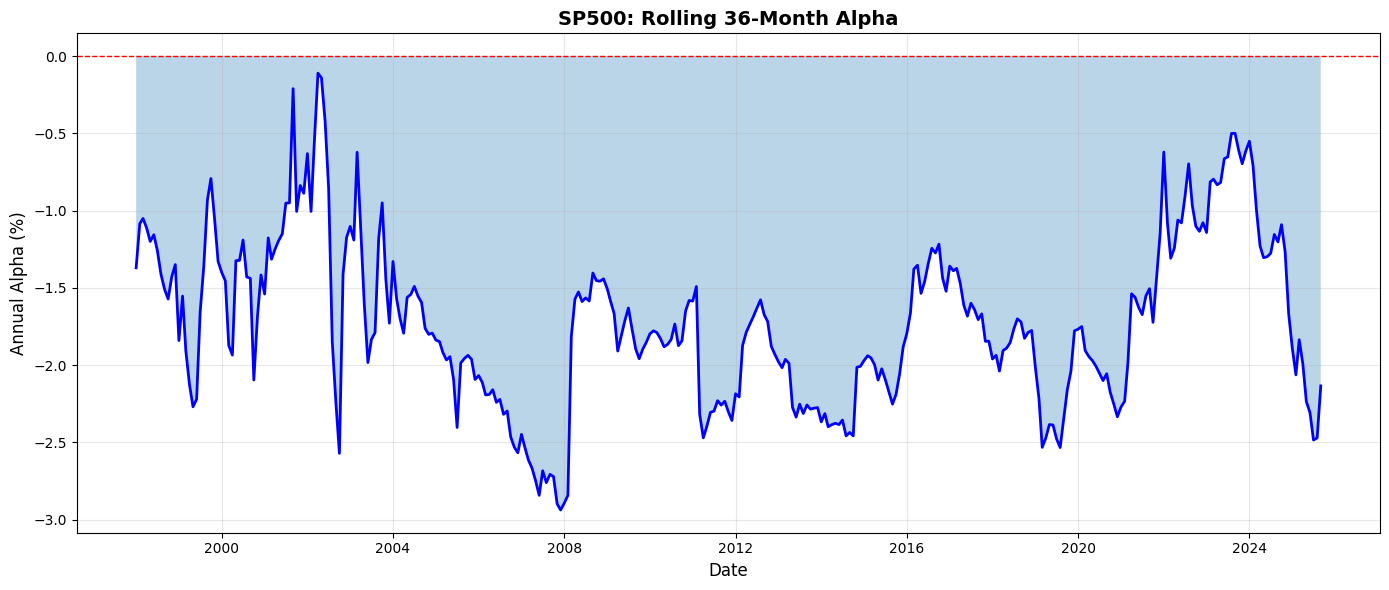

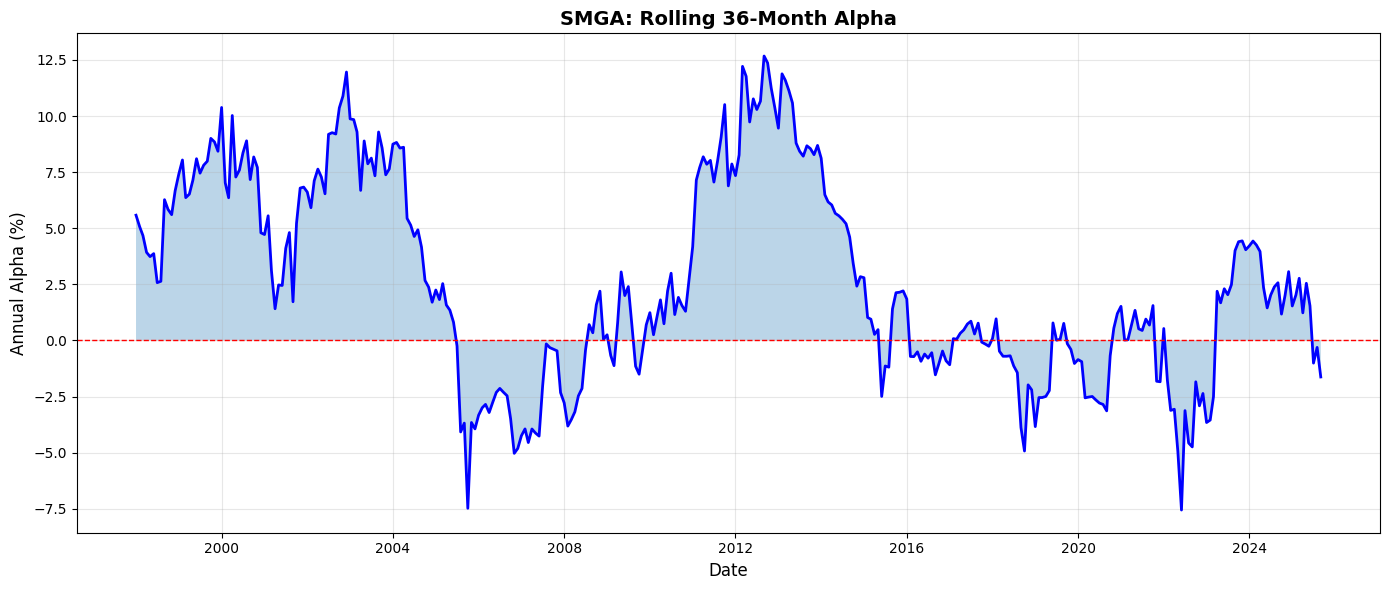

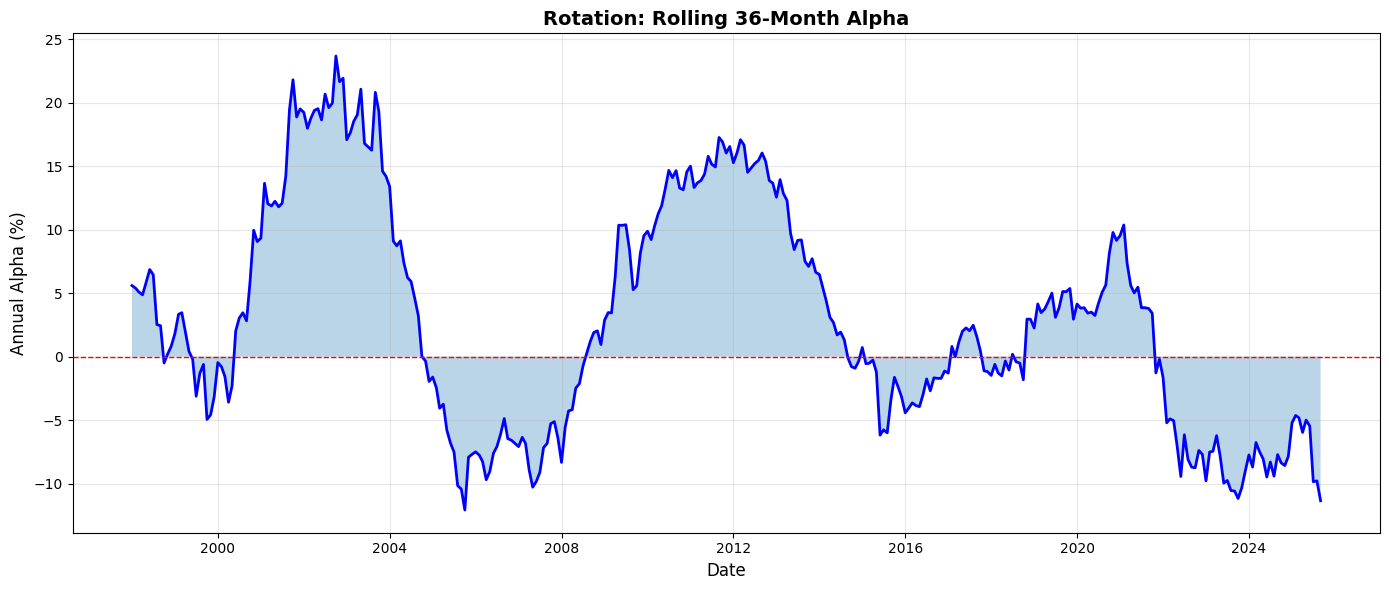

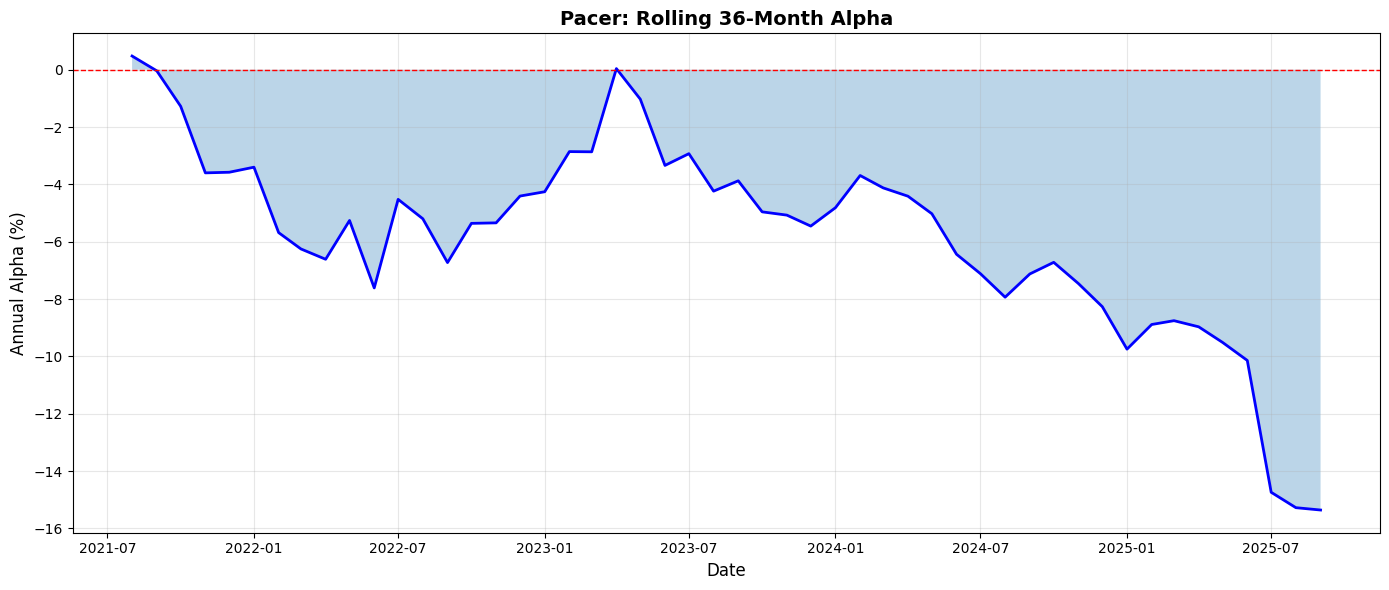

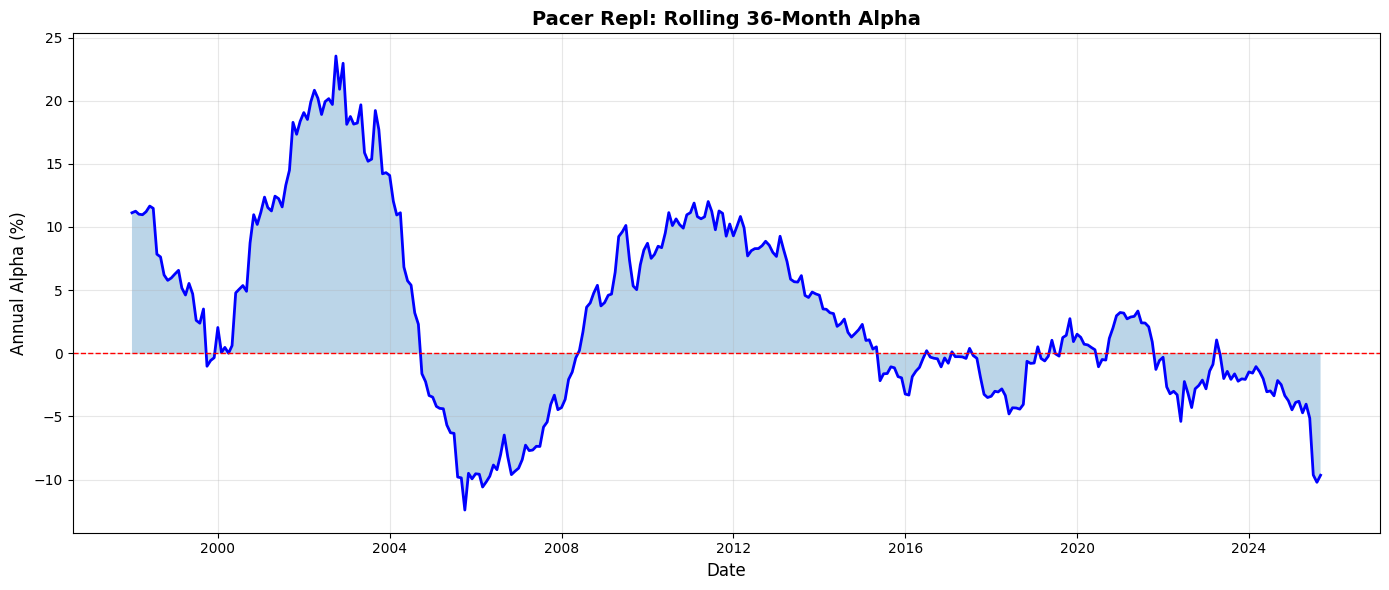

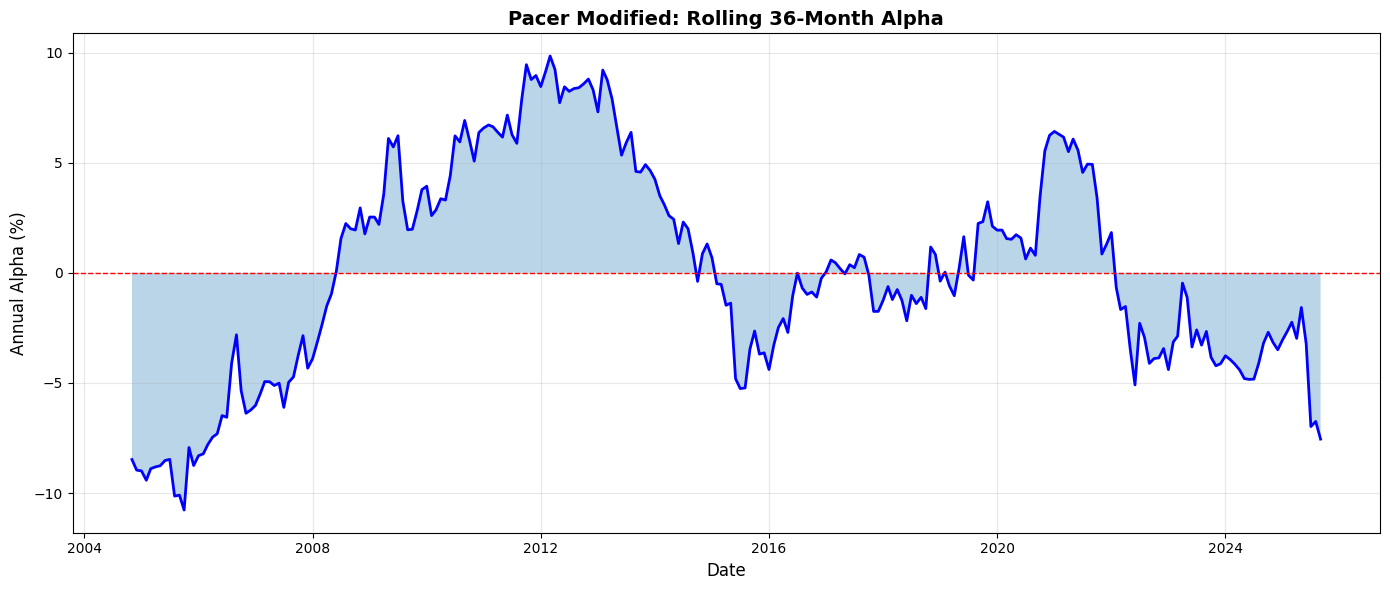

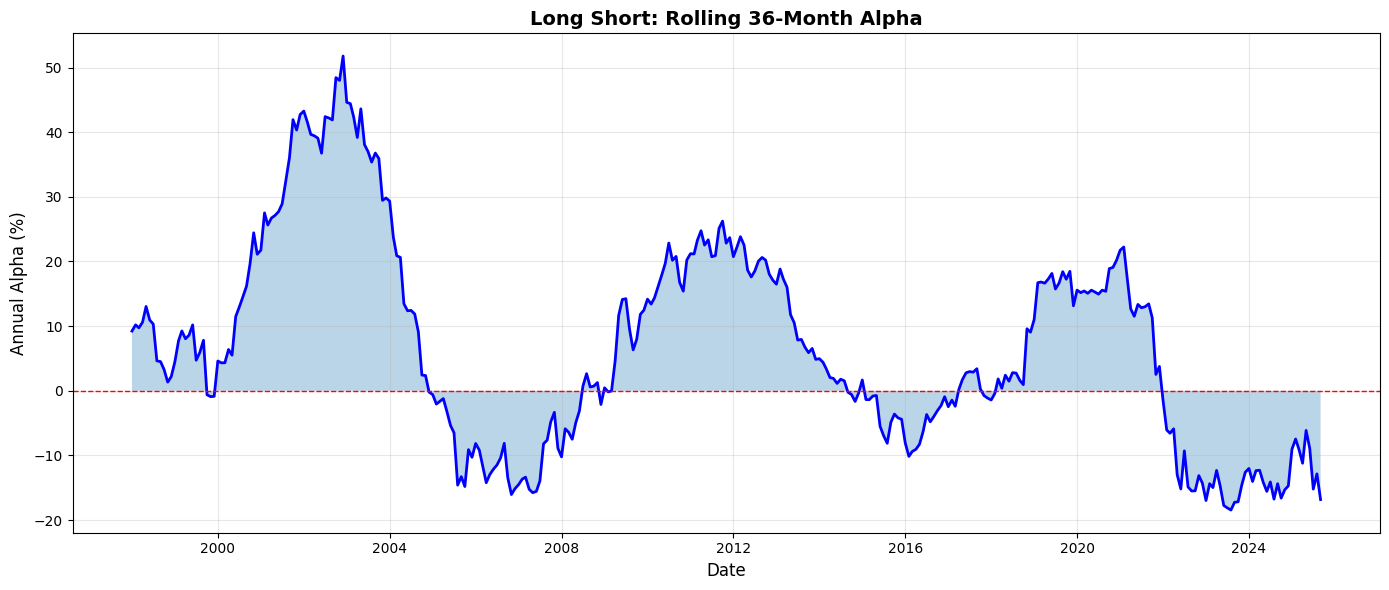

In [35]:
strategies = { 
    "SP500": sp500_excess["excess"],
    "SMGA": smga_excess["excess"],
    "Rotation": rotation_returns["excess"],
    "Pacer": pacer_returns["excess"],
    "Pacer Repl": pacer_returns_repl["excess"],
    "Pacer Modified": modified_pacer["excess"],
    "Long Short": long_short["excess"],
}

for strategy, returns in strategies.items():
    plot_rolling_alpha(returns, factors_df, strategy_name=strategy)